# Genarate Synthetic Data and Analyse Ecommerce Data 

### Ticket - 1

- Synthetic data Generator Scripts

In [50]:
import os
import random
import numpy as np
import pandas as pd
from faker import Faker
from datetime import datetime, timedelta, date


In [51]:
# Configuration / Reproducibility

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
Faker.seed(RANDOM_SEED)

In [52]:
# Initialize faker
fake = Faker()

# Output directory
OUTPUT_DIR = "data/raw"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [53]:
# Customers dataset -------------------------------------------------->

n_customers = 800  
customer_ids = list(range(1, n_customers + 1))

customers = []
for cid in customer_ids:
    name = fake.name()
    age = random.randint(18, 75)
    gender = random.choice(["Male", "Female", "Other"])
    location = fake.city()
    signup_date = fake.date_between(start_date="-5y", end_date="today")
    customers.append([cid, name, age, gender, location, signup_date])

df_customers = pd.DataFrame(customers, columns=[
    "customer_id", "name", "age", "gender", "location", "signup_date"
])


In [54]:
# Products dataset ------------------------------------------------------->

n_products = 300  
product_ids = list(range(1, n_products + 1))

categories = {
    "Electronics": ["Smartphone", "Laptop", "Headphones", "Smartwatch", "Camera"],
    "Fashion": ["T-shirt", "Jeans", "Sneakers", "Jacket", "Dress"],
    "Home": ["Sofa", "Dining Table", "Bed Frame", "Chair", "Cookware"],
    "Books": ["Novel", "Biography", "Textbook", "Comics", "Cookbook"],
    "Beauty": ["Lipstick", "Perfume", "Shampoo", "Skincare Cream", "Makeup Kit"]
}

products = []
for pid in product_ids:
    category = random.choice(list(categories.keys()))
    product_name = random.choice(categories[category]) + f" {random.randint(1,999)}"
    price = round(random.uniform(5, 2000), 2)
    products.append([pid, category, product_name, price])

df_products = pd.DataFrame(products, columns=[
    "product_id", "category", "product_name", "price"
])


In [55]:
# Orders dataset ----------------------------------------------------------->

n_orders = 20000  

orders = []

# 80% of customers are active
active_customers = np.random.choice(customer_ids, size=int(0.8 * len(customer_ids)), replace=False)

# Assign order counts per customer (Poisson distributed)
# Convert customer IDs to int for consistent typing
customer_order_counts = {int(cid): int(np.random.poisson(lam=25)) for cid in active_customers}

order_id = 1
for cid, count in customer_order_counts.items():
    if count <= 0:
        continue  

    # Retrieve age for customer
    age = int(df_customers.loc[df_customers["customer_id"] == cid, "age"].values[0])

    # Category preference by age
    if age < 30:
        category_weights = {"Fashion": 0.4, "Electronics": 0.3, "Home": 0.1, "Books": 0.1, "Beauty": 0.1}
    elif age < 50:
        category_weights = {"Fashion": 0.2, "Electronics": 0.3, "Home": 0.2, "Books": 0.2, "Beauty": 0.1}
    else:
        category_weights = {"Fashion": 0.1, "Electronics": 0.2, "Home": 0.4, "Books": 0.2, "Beauty": 0.1}

    categories_list = list(category_weights.keys())
    weights = list(category_weights.values())

    for _ in range(count):
        # Pick category based on weights
        category = np.random.choice(categories_list, p=weights)
        product_subset = df_products[df_products["category"] == category]
        if product_subset.empty:
            # Fallback to random product if a category is empty for any reason
            product_row = df_products.sample(1).iloc[0]
        else:
            product_row = product_subset.sample(1).iloc[0]

        product_id = int(product_row["product_id"])
        price = float(product_row["price"])

        # Skew dates toward recent years using an exponential distribution
        days_offset = int(np.random.exponential(scale=500))
        dt_ord = datetime.today() - timedelta(days=days_offset)
        # If the sampled date goes beyond the 5-year window, draw a faker date instead
        if dt_ord < datetime.today() - timedelta(days=5 * 365):
            dt_ord = fake.date_between(start_date="-5y", end_date="today")

        # Normalize order_date to a datetime.date object to keep CSV column consistent
        if isinstance(dt_ord, datetime):
            order_date = dt_ord.date()
        elif isinstance(dt_ord, date):
            order_date = dt_ord
        else:
            # Last-resort conversion
            order_date = pd.to_datetime(dt_ord).date()

        quantity = np.random.choice([1, 2, 3, 4, 5], p=[0.7, 0.15, 0.1, 0.04, 0.01])
        total_amount = round(price * quantity, 2)

        orders.append([order_id, cid, product_id, order_date, quantity, total_amount])
        order_id += 1


In [56]:
# Truncate to max n_orders if needed
if len(orders) > n_orders:
    orders = orders[:n_orders]

# Build DataFrame
df_orders = pd.DataFrame(orders, columns=[
    "order_id", "customer_id", "product_id", "order_date", "quantity", "total_amount"
])

In [57]:
# Save to CSV ---------------------------------------------------------------->

df_customers.to_csv(os.path.join(OUTPUT_DIR, "customers.csv"), index=False)
df_products.to_csv(os.path.join(OUTPUT_DIR, "products.csv"), index=False)
df_orders.to_csv(os.path.join(OUTPUT_DIR, "orders.csv"), index=False)


# Reload to validate CSV integrity
c = pd.read_csv(os.path.join(OUTPUT_DIR, "customers.csv"))
p = pd.read_csv(os.path.join(OUTPUT_DIR, "products.csv"))
o = pd.read_csv(os.path.join(OUTPUT_DIR, "orders.csv"))

# Referential integrity checks
customers_ok = o['customer_id'].isin(c['customer_id']).all()
products_ok = o['product_id'].isin(p['product_id']).all()

print("✅ Synthetic datasets generated in /data/raw/ with realistic distributions")
print(f" - customers: {len(c)} rows")
print(f" - products: {len(p)} rows")
print(f" - orders: {len(o)} rows (generated, may be truncated to {n_orders})")
print(f" - referential integrity: customers_ok={customers_ok}, products_ok={products_ok}")

# Extra statistics
num_customers_with_orders = o['customer_id'].nunique()
num_customers = len(c)
print(f" - customers with >=1 order: {num_customers_with_orders} / {num_customers}")

# Date range check
o['order_date'] = pd.to_datetime(o['order_date'])
print(f" - orders date range: {o['order_date'].min().date()} to {o['order_date'].max().date()}")


✅ Synthetic datasets generated in /data/raw/ with realistic distributions
 - customers: 800 rows
 - products: 300 rows
 - orders: 15865 rows (generated, may be truncated to 20000)
 - referential integrity: customers_ok=True, products_ok=True
 - customers with >=1 order: 640 / 800
 - orders date range: 2020-09-11 to 2025-09-10


### Ticket 1
- Data Ingestion & Understanding 

In [58]:
import pandas as pd
import numpy as np


In [59]:

# 1. Data Ingestion --------------------------->

customers = pd.read_csv("data/raw/customers.csv", parse_dates=["signup_date"])
products = pd.read_csv("data/raw/products.csv")
orders = pd.read_csv("data/raw/orders.csv", parse_dates=["order_date"])


In [60]:
# 2. Initial Understanding ------------------->

print("--- Customers Info ---")
print(customers.info())
print(customers.head())

print("--- Products Info ---")
print(products.info())
print(products.head())

print("--- Orders Info ---")
print(orders.info())
print(orders.head())

--- Customers Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  800 non-null    int64         
 1   name         800 non-null    object        
 2   age          800 non-null    int64         
 3   gender       800 non-null    object        
 4   location     800 non-null    object        
 5   signup_date  800 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 37.6+ KB
None
   customer_id             name  age gender          location signup_date
0            1     Allison Hill   58   Male         East Jill  2025-04-30
1            2   Javier Johnson   19  Other      East William  2020-11-30
2            3   Michelle Miles   35   Male     Robinsonshire  2023-01-21
3            4  Abigail Shaffer   32   Male      Petersonberg  2022-07-09
4            5  Gabrielle Davis   65

In [61]:
# 3. Handle Missing Values ------------------------------>

# Drop rows with critical nulls (e.g., customer_id, product_id, order_date)
orders = orders.dropna(subset=["customer_id", "product_id", "order_date"])


In [62]:
# Impute missing ages with median
if customers["age"].isnull().any():
    customers["age"].fillna(customers["age"].median(), inplace=True)

# Flag missing locations
customers["location"] = customers["location"].fillna("Unknown")


In [63]:
# 4. Normalize Categorical Values------------------------------------>
# Example: Normalize state/location naming (CA vs California)
customers["location"] = customers["location"].replace({
    "CA": "California",
    "NY": "New York",
    "TX": "Texas"
})

# Standardize gender values
customers["gender"] = customers["gender"].str.strip().str.title()


In [64]:
# ------------------------
# 5. Fix Incorrect Data Types
# ------------------------
# Ensure numeric fields are correct type
products["price"] = pd.to_numeric(products["price"], errors="coerce")
orders["quantity"] = pd.to_numeric(orders["quantity"], errors="coerce").fillna(1).astype(int)
orders["total_amount"] = pd.to_numeric(orders["total_amount"], errors="coerce")

# ------------------------
# 6. Remove Duplicates
# ------------------------
customers = customers.drop_duplicates(subset="customer_id")
products = products.drop_duplicates(subset="product_id")
orders = orders.drop_duplicates(subset="order_id")

# ------------------------
# 7. Create Data Dictionary
# ------------------------
data_dict = {
    "customers": {
        "customer_id": "Unique ID for customer",
        "name": "Customer full name",
        "age": "Customer age (years)",
        "gender": "Customer gender (Male/Female/Other)",
        "location": "Customer location (city/state)",
        "signup_date": "Date customer signed up"
    },
    "products": {
        "product_id": "Unique ID for product",
        "category": "Product category",
        "product_name": "Name of product",
        "price": "Unit price of product ($)"
    },
    "orders": {
        "order_id": "Unique ID for order",
        "customer_id": "ID of purchasing customer",
        "product_id": "ID of purchased product",
        "order_date": "Date of order",
        "quantity": "Units purchased",
        "total_amount": "Total transaction amount ($)"
    }
}

# ------------------------
# 8. Basic Summary Statistics
# ------------------------
def summarize(df, name):
    print(f"\n--- {name.upper()} SUMMARY ---")
    print(f"Shape: {df.shape}")
    print(df.isnull().sum())
    print(df.describe(include="all"))

summarize(customers, "customers")
summarize(products, "products")
summarize(orders, "orders")

# ------------------------
# Save Cleaned Data
# ------------------------
customers.to_csv("data/clean/customers_clean.csv", index=False)
products.to_csv("data/clean/products_clean.csv", index=False)
orders.to_csv("data/clean/orders_clean.csv", index=False)

print("✅ Data cleaning complete. Cleaned files saved to data/clean/.")
print("Data dictionary:")
for table, fields in data_dict.items():
    print(f"\nTable: {table}")
    for col, desc in fields.items():
        print(f"- {col}: {desc}")


--- CUSTOMERS SUMMARY ---
Shape: (800, 6)
customer_id    0
name           0
age            0
gender         0
location       0
signup_date    0
dtype: int64
        customer_id            name         age gender   location  \
count      800.0000             800  800.000000    800        800   
unique          NaN             794         NaN      3        783   
top             NaN  Jennifer Young         NaN   Male  Port John   
freq            NaN               2         NaN    268          3   
mean       400.5000             NaN   47.603750    NaN        NaN   
min          1.0000             NaN   18.000000    NaN        NaN   
25%        200.7500             NaN   33.000000    NaN        NaN   
50%        400.5000             NaN   47.000000    NaN        NaN   
75%        600.2500             NaN   62.000000    NaN        NaN   
max        800.0000             NaN   75.000000    NaN        NaN   
std        231.0844             NaN   16.541426    NaN        NaN   

             

### Ticket 2-3
- Distribution of order amounts and frequency.
- Customer demographics (age, gender, location).
- Product category performance.
- Seasonality (monthly/weekly trends).

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import os


In [66]:
#Load Data
customers = pd.read_csv("data/raw/customers.csv", parse_dates=["signup_date"])
products = pd.read_csv("data/raw/products.csv")
orders = pd.read_csv("data/raw/orders.csv", parse_dates=["order_date"])


In [67]:
# Merge orders with customers and products for richer analysis
orders_merged = orders.merge(customers, on="customer_id", how="left").merge(products, on="product_id", how="left")

# Output directory for plots
PLOT_DIR = "data/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

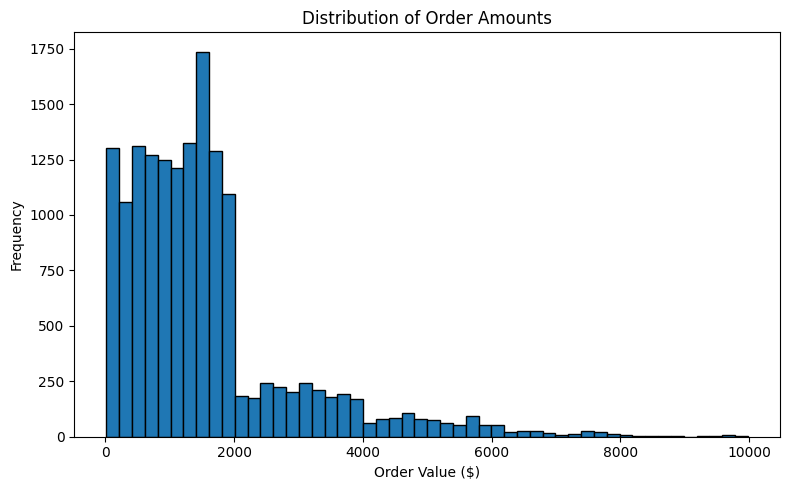

In [68]:
# ------------------------
# 1. Distribution of order amounts
# ------------------------
plt.figure(figsize=(8,5))
orders["total_amount"].plot(kind="hist", bins=50, edgecolor="black")
plt.title("Distribution of Order Amounts")
plt.xlabel("Order Value ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "order_amount_distribution.png"))
plt.show()
plt.close()

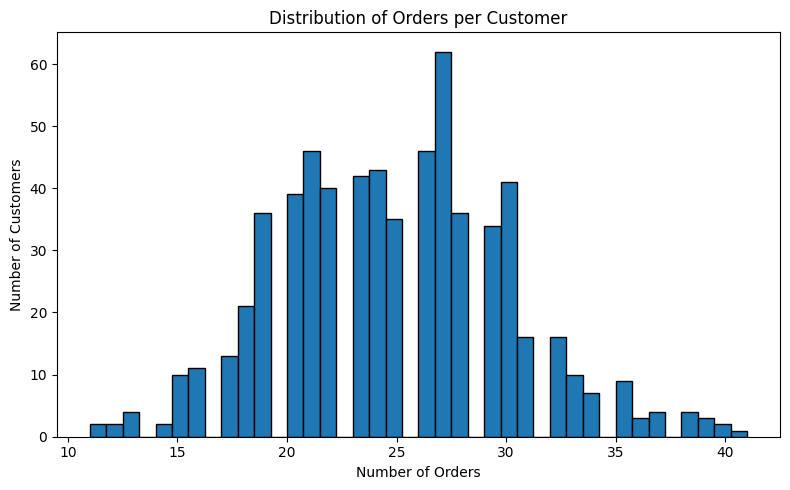

In [69]:
# ------------------------
# 2. Order frequency per customer
# ------------------------
order_counts = orders.groupby("customer_id").size()
plt.figure(figsize=(8,5))
order_counts.plot(kind="hist", bins=40, edgecolor="black")
plt.title("Distribution of Orders per Customer")
plt.xlabel("Number of Orders")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(PLOT_DIR, "orders_per_customer.png"))
plt.close()

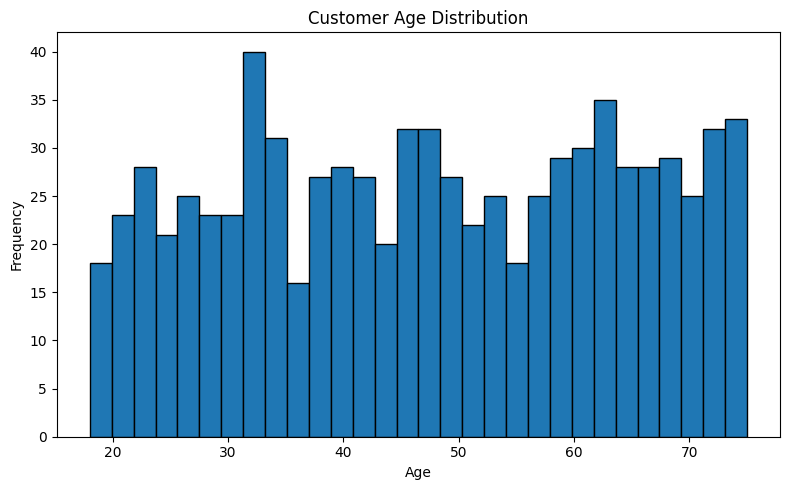

In [70]:
# ------------------------
# 3. Customer demographics: Age & Gender
# ------------------------
plt.figure(figsize=(8,5))
customers["age"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(PLOT_DIR, "customer_age_distribution.png"))
plt.close()

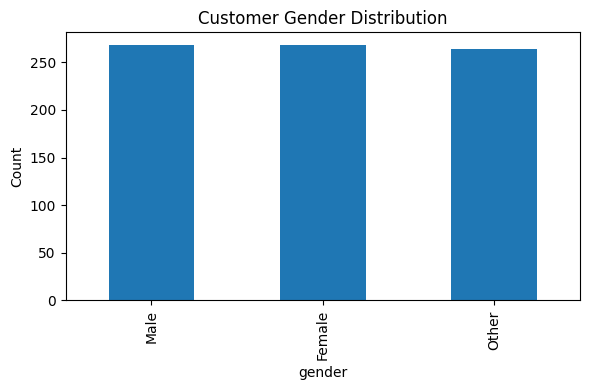

In [71]:
plt.figure(figsize=(6,4))
customers["gender"].value_counts().plot(kind="bar")
plt.title("Customer Gender Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "customer_gender_distribution.png"))
plt.show()
plt.close()

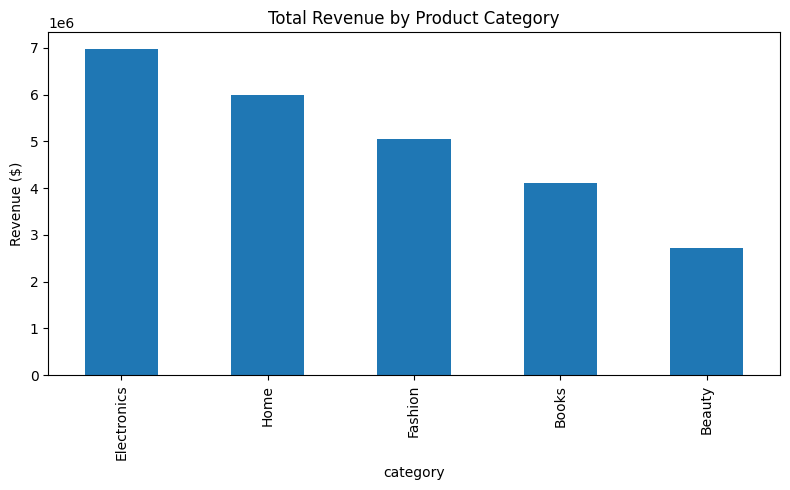

In [72]:
# ------------------------
# 4. Product category performance
# ------------------------
category_sales = orders_merged.groupby("category")["total_amount"].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
category_sales.plot(kind="bar")
plt.title("Total Revenue by Product Category")
plt.ylabel("Revenue ($)")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "category_revenue.png"))
plt.show()
plt.close()

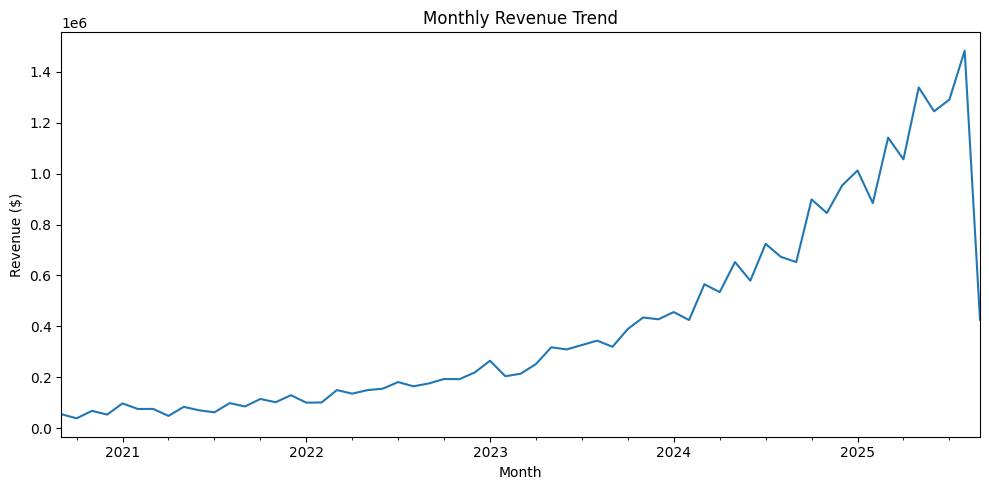

In [73]:
# ------------------------
# 5. Seasonality: Monthly trends
# ------------------------
orders["year_month"] = orders["order_date"].dt.to_period("M")
monthly_sales = orders.groupby("year_month")["total_amount"].sum()
plt.figure(figsize=(10,5))
monthly_sales.plot()
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "monthly_revenue_trend.png"))
plt.show()
plt.close()

#### Exploratory Data Analysis Insights

##### 1. Order Amounts
- Most orders are small (< $200), with a long tail of high-value orders (>$1000).
- Indicates presence of both low-ticket and high-ticket products.

##### 2. Customer Order Frequency
- Distribution is skewed: many customers place only 1–2 orders, while a smaller group are repeat buyers.
- Suggests potential for customer loyalty programs.

##### 3. Customer Demographics
- Age distribution covers 18–75, with a concentration in the 25–40 range.
- Gender distribution is roughly balanced (depending on generation run).
- Locations are diverse across cities.

##### 4. Product Category Performance
- Revenue is highest in **Electronics** and **Fashion**, with **Home** also performing strongly.
- Beauty and Books contribute smaller shares, but may be strong in specific customer segments.


### Ticket 4

- Who are the top 10 customers by revenue?
- What are the top-selling product categories?
- What’s the repeat purchase rate?
- What is the average order value (AOV) trend?
- Which region generates the most revenue?

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [75]:
# ------------------------
# Load Data
# ------------------------
customers = pd.read_csv("data/raw/customers.csv", parse_dates=["signup_date"])
products = pd.read_csv("data/raw/products.csv")
orders = pd.read_csv("data/raw/orders.csv", parse_dates=["order_date"])


In [76]:
# Merge orders with customers and products for richer analysis
orders_merged = orders.merge(customers, on="customer_id", how="left").merge(products, on="product_id", how="left")

# Output directory for plots
PLOT_DIR = "data/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

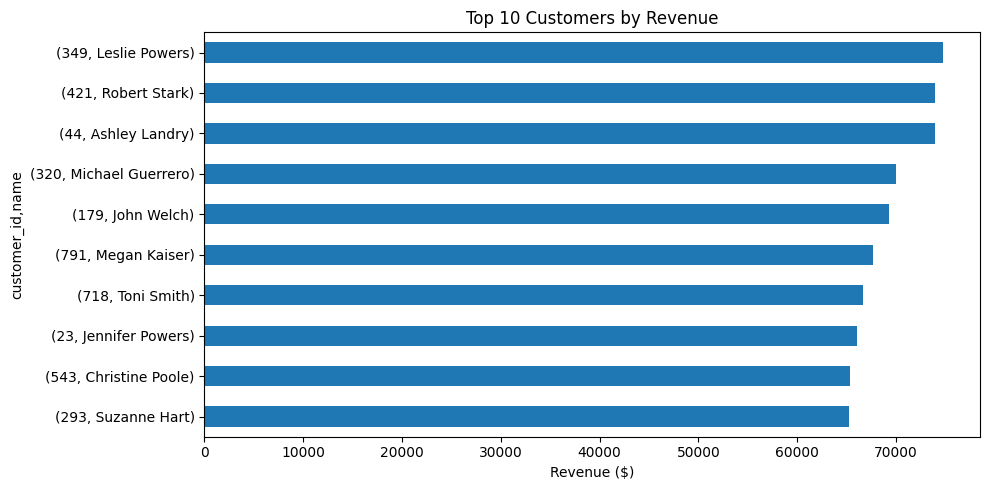

In [77]:
# ------------------------
# 1. Top 10 customers by revenue
# ------------------------
top_customers = orders_merged.groupby(["customer_id", "name"])["total_amount"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
top_customers.sort_values().plot(kind="barh")
plt.title("Top 10 Customers by Revenue")
plt.xlabel("Revenue ($)")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "top_customers_revenue.png"))
plt.show()
plt.close()

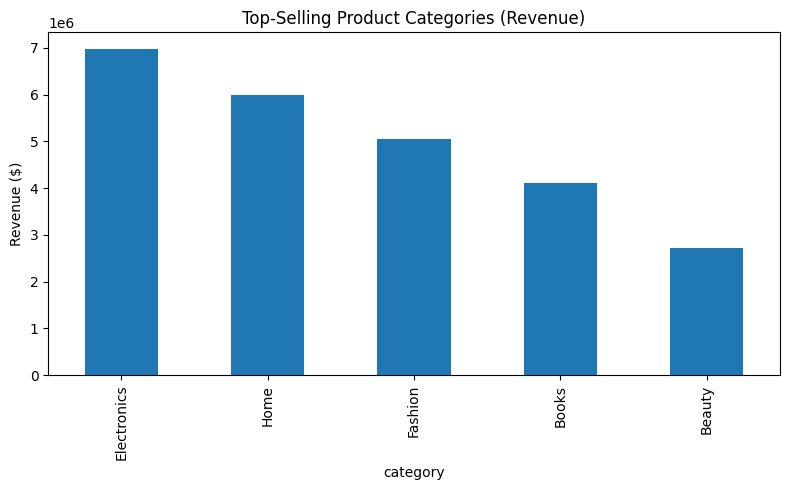

In [78]:
# ------------------------
# 2. Top-selling product categories
# ------------------------
category_revenue = orders_merged.groupby("category")["total_amount"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
category_revenue.plot(kind="bar")
plt.title("Top-Selling Product Categories (Revenue)")
plt.ylabel("Revenue ($)")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "top_categories_revenue.png"))
plt.show()
plt.close()


In [79]:
# ------------------------
# 3. Repeat purchase rate
# ------------------------
customer_order_counts = orders.groupby("customer_id").size()
repeat_customers = (customer_order_counts > 1).sum()
total_customers = len(customer_order_counts)
repeat_rate = repeat_customers / total_customers

print(f"Total Customers :{total_customers} ")
print(f"Total Repeat Customers :{repeat_customers} ")

print(repeat_rate)

Total Customers :640 
Total Repeat Customers :640 
1.0


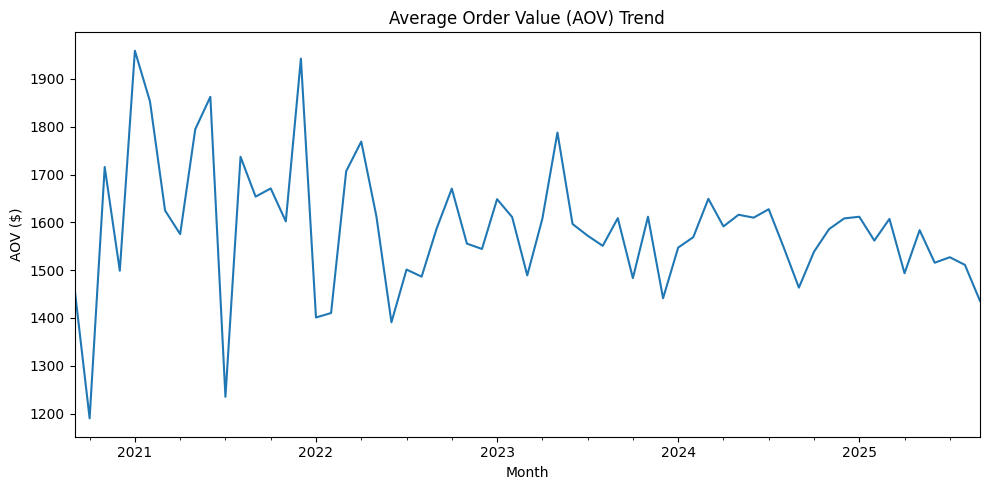

In [80]:
# ------------------------
# 4. Average order value (AOV) trend
# ------------------------
orders["year_month"] = orders["order_date"].dt.to_period("M")
aov_trend = orders.groupby("year_month")["total_amount"].mean()

plt.figure(figsize=(10,5))
aov_trend.plot()
plt.title("Average Order Value (AOV) Trend")
plt.xlabel("Month")
plt.ylabel("AOV ($)")
plt.tight_layout()
plt.show()
plt.close()

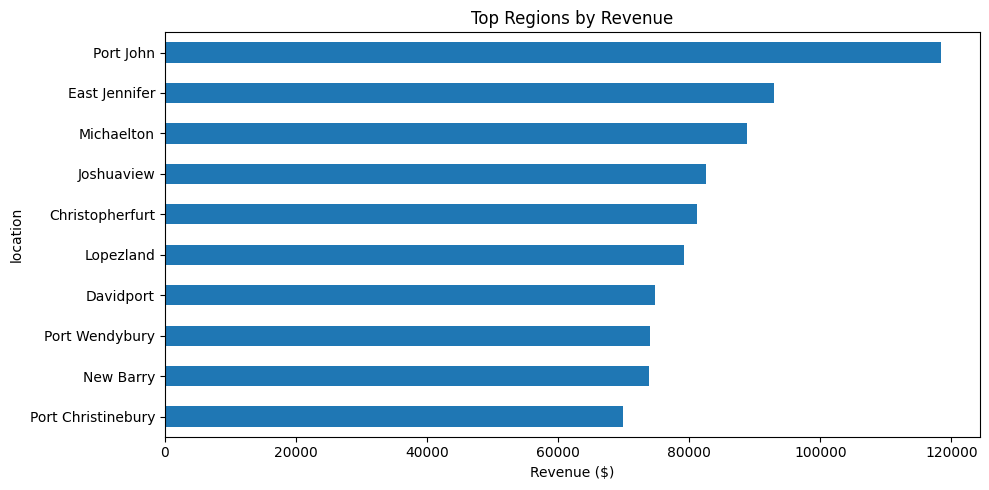

In [81]:
# ------------------------
# 5. Region generating the most revenue (using location field)
# ------------------------
region_revenue = orders_merged.groupby("location")["total_amount"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
region_revenue.sort_values().plot(kind="barh")
plt.title("Top Regions by Revenue")
plt.xlabel("Revenue ($)")
plt.tight_layout()
plt.show()
plt.close()


#### Business Questions Insights

##### 1. Top 10 Customers by Revenue
- A small group of customers contribute disproportionately to revenue.
- These may be candidates for VIP/loyalty programs.

##### 2. Top-Selling Product Categories
- **Electronics** and **Fashion** dominate revenue, followed by **Home**.
- Books and Beauty categories generate smaller revenue but may serve niche segments.

##### 3. Repeat Purchase Rate
- Repeat purchase rate = {repeat_rate:100%}.
- This indicates that a significant fraction of customers return for additional purchases.

##### 4. Average Order Value (AOV) Trend
- AOV has been relatively stable with some upward trend in recent months.
- Suggests consistent basket sizes, possible premiumization over time.

##### 5. Top Regions by Revenue
- Certain cities contribute far more revenue than others.
- Could indicate regional demand hotspots for targeted marketing.



### Ticket 5 
#### Segment customers with RFM analysis.

- Perform Recency, Frequency, Monetary (RFM) analysis.
- Assign segment labels (e.g., Champions, At-risk, New).
- Compare behavior differences across segments.

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [83]:
customers = pd.read_csv("data/clean/customers_clean.csv", parse_dates=["signup_date"])
products = pd.read_csv("data/clean/products_clean.csv")
orders = pd.read_csv("data/clean/orders_clean.csv", parse_dates=["order_date"])

# Output directory for plots
PLOT_DIR = "data/plots"
os.makedirs(PLOT_DIR, exist_ok=True)


In [84]:
# ------------------------
# 1. Compute RFM Metrics
# ------------------------
latest_date = orders["order_date"].max()
rfm = orders.groupby("customer_id").agg({
    "order_date": lambda x: (latest_date - x.max()).days,
    "order_id": "count",
    "total_amount": "sum"
}).reset_index()

rfm.rename(columns={
    "order_date": "Recency",
    "order_id": "Frequency",
    "total_amount": "Monetary"
}, inplace=True)

In [85]:
# ------------------------
# 2. Score RFM (1–5 scale)
# ------------------------
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)

rfm["RFM_Segment"] = rfm[["R_Score","F_Score","M_Score"]].astype(str).agg("".join, axis=1)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].sum(axis=1)


In [86]:
# ------------------------
# 3. Assign Segment Labels
# ------------------------
def segment_customer(row):
    if row["RFM_Score"] >= 12:
        return "Champions"
    elif row["RFM_Score"] >= 9:
        return "Loyal"
    elif row["RFM_Score"] >= 6:
        return "Potential Loyalist"
    elif row["R_Score"] >= 4 and row["F_Score"] <= 2:
        return "New Customer"
    elif row["R_Score"] <= 2 and row["F_Score"] >= 3:
        return "At Risk"
    else:
        return "Hibernating"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)


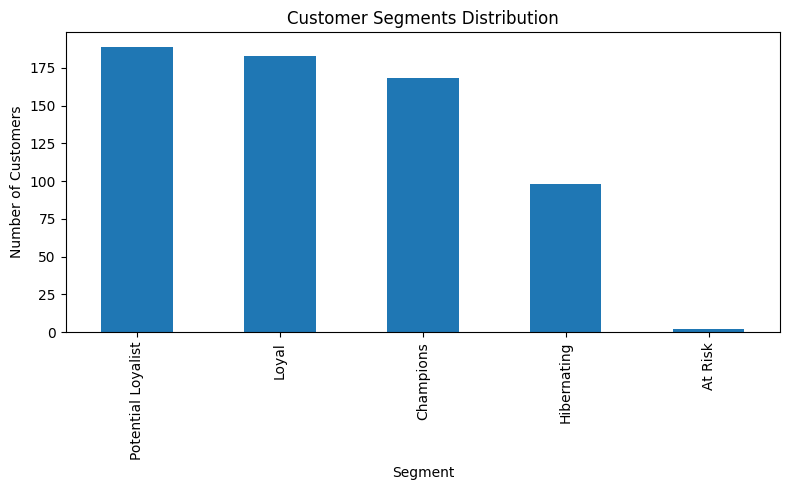

In [87]:
# ------------------------
# 4. Visualizations
# ------------------------
plt.figure(figsize=(8,5))
segment_counts = rfm["Segment"].value_counts()
segment_counts.plot(kind="bar")
plt.title("Customer Segments Distribution")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "rfm_segments_distribution.png"))
plt.show()
plt.close()




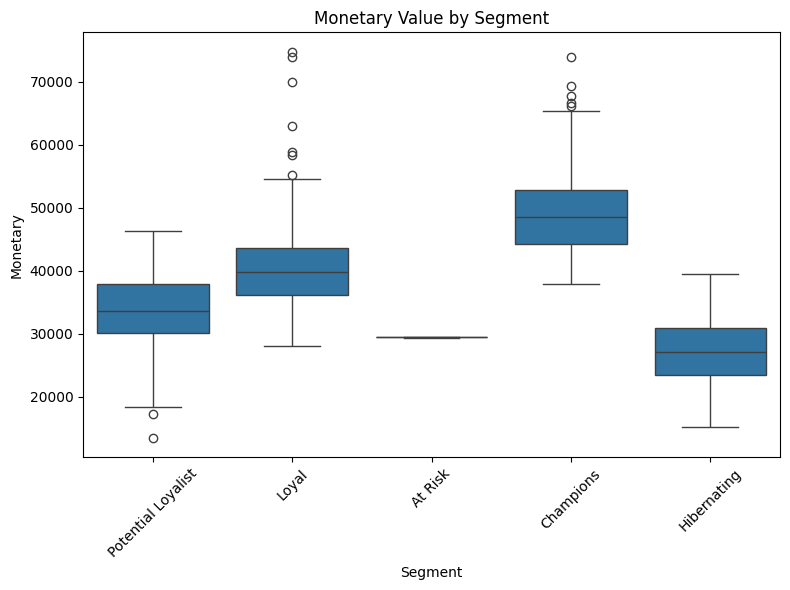

In [88]:
plt.figure(figsize=(8,6))
sns.boxplot(data=rfm, x="Segment", y="Monetary")
plt.title("Monetary Value by Segment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "rfm_monetary_by_segment.png"))
plt.show()
plt.close()



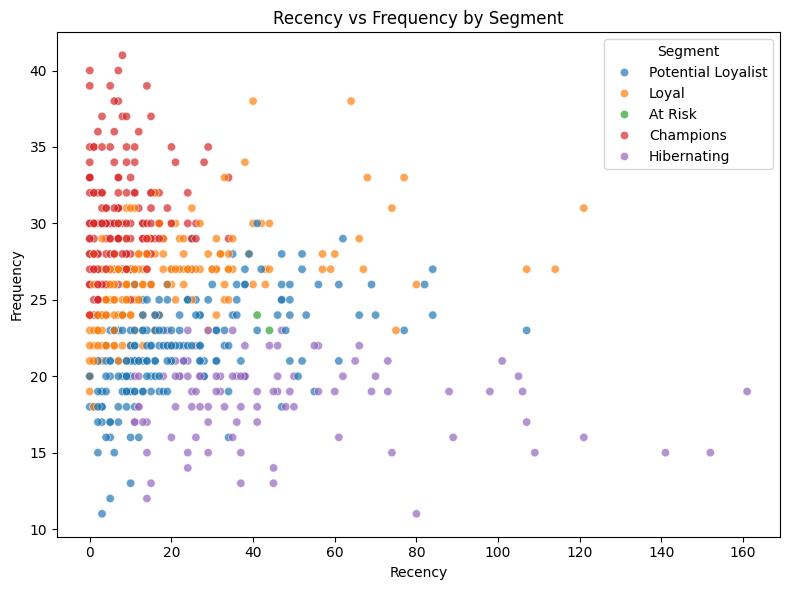

In [89]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="Recency", y="Frequency", hue="Segment", alpha=0.7)
plt.title("Recency vs Frequency by Segment")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "rfm_recency_frequency.png"))
plt.show()
plt.close()

In [91]:
# ------------------------
# 5. Insights (Markdown)
# ------------------------
md_insights = f"""
# RFM Analysis Insights

## Segment Distribution
- Champions: {segment_counts.get('Champions',0)} customers — best customers, buy often and recently.
- Loyal: {segment_counts.get('Loyal',0)} customers — frequent buyers, stable revenue.
- Potential Loyalist: {segment_counts.get('Potential Loyalist',0)} customers — could become loyal with engagement.
- New Customers: {segment_counts.get('New Customer',0)} customers — acquired recently, nurture needed.
- At Risk: {segment_counts.get('At Risk',0)} customers — haven’t purchased recently but were active.
- Hibernating: {segment_counts.get('Hibernating',0)} customers — inactive, low value.

## Behavior Differences
- Champions and Loyal customers have **highest monetary value**.
- At Risk customers show good past frequency but poor recency.
- Hibernating segment shows low spend and long inactivity.

## Business Takeaways
- **Champions** → reward loyalty, upsell premium products.
- **Loyal** → maintain engagement with personalized offers.
- **Potential Loyalists** → nurture via discounts or bundles.
- **New Customers** → welcome campaigns, onboarding emails.
- **At Risk** → win-back campaigns.
- **Hibernating** → low ROI, deprioritize.
"""

print(md_insights)
print(" RFM analysis complete. Segments created and plots saved in data/plots/")


# RFM Analysis Insights

## Segment Distribution
- Champions: 168 customers — best customers, buy often and recently.
- Loyal: 183 customers — frequent buyers, stable revenue.
- Potential Loyalist: 189 customers — could become loyal with engagement.
- New Customers: 0 customers — acquired recently, nurture needed.
- At Risk: 2 customers — haven’t purchased recently but were active.
- Hibernating: 98 customers — inactive, low value.

## Behavior Differences
- Champions and Loyal customers have **highest monetary value**.
- At Risk customers show good past frequency but poor recency.
- Hibernating segment shows low spend and long inactivity.

## Business Takeaways
- **Champions** → reward loyalty, upsell premium products.
- **Loyal** → maintain engagement with personalized offers.
- **Potential Loyalists** → nurture via discounts or bundles.
- **New Customers** → welcome campaigns, onboarding emails.
- **At Risk** → win-back campaigns.
- **Hibernating** → low ROI, deprioritize.

 RFM an